# COMP90051 Workshop 2
## Part A: Linear regression

***

Our aim for this part of the workshop is to fit a linear model from scratch—relying only on the `numpy` library. We'll experiment with two implementations: one based on iterative updates (coordinate descent) and another based on linear algebra. Finally, to check the correctness of our implementation, we'll compare its output to the output of `sklearn`.

Firstly we will import the relevant libraries (`numpy`, `matplotlib`, etc.).

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import io

To check what a command does simply type `object?`. For example:

In [3]:
np.arange?

Docstring:
arange([start,] stop[, step,], dtype=None)

Return evenly spaced values within a given interval.

Values are generated within the half-open interval ``[start, stop)``
(in other words, the interval including `start` but excluding `stop`).
For integer arguments the function is equivalent to the Python built-in
`range` function, but returns an ndarray rather than a list.

When using a non-integer step, such as 0.1, the results will often not
be consistent.  It is better to use `numpy.linspace` for these cases.

Parameters
----------
start : number, optional
    Start of interval.  The interval includes this value.  The default
    start value is 0.
stop : number
    End of interval.  The interval does not include this value, except
    in some cases where `step` is not an integer and floating point
    round-off affects the length of `out`.
step : number, optional
    Spacing between values.  For any output `out`, this is the distance
    between two adjacent values, ``out[i+1]

### 1. Review
In lectures, we saw that a linear model can be expressed as:
$$y = w_0 + \sum_{j = 1}^{m} w_j x_j = \mathbf{w} \cdot \mathbf{x} $$
where 

* $y$ is the *target variable*;
* $\mathbf{x} = [x_1, \ldots, x_m]$ 
is a vector of *features* (we define $x_0 = 1$); and
* $\mathbf{w} = [w_0, \ldots, w_m]$ 
are the *weights*.

To fit the model, we *minimise* the empirical risk with respect to $\vec{w}$. In this simplest case (square loss), this amounts to minimising the sum of squared residuals:

$$SSR(\mathbf{w}) = \sum_{i=1}^{n}(y_i - \mathbf{w} \cdot \mathbf{x}_i)^2$$

**Note:** For simplicity, we'll consider the case $m = 1$ (i.e. only one feature excluding the intercept).

### 2. Data set
We'll be working with some data from the Olympics—the gold medal race times for marathon winners from 1896 to 2012. The code block below reads the data into a numpy array of floats, and prints the result.

In [4]:
# CSV file with variables YEAR,TIME
csv = """1896,4.47083333333333
1900,4.46472925981123
1904,5.22208333333333
1908,4.1546786744085
1912,3.90331674958541
1920,3.5695126705653
1924,3.8245447722874
1928,3.62483706600308
1932,3.59284275388079
1936,3.53880791562981
1948,3.6701030927835
1952,3.39029110874116
1956,3.43642611683849
1960,3.2058300746534
1964,3.13275664573212
1968,3.32819844373346
1972,3.13583757949204
1976,3.07895880238575
1980,3.10581822490816
1984,3.06552909112454
1988,3.09357348817
1992,3.16111703598373
1996,3.14255243512264
2000,3.08527866650867
2004,3.1026582928467
2008,2.99877552632618
2012,3.03392977050993"""

# Read into a numpy array (as floats)
olympics = np.genfromtxt(io.BytesIO(csv.encode()), delimiter=",")
print(olympics)

[[1896.            4.47083333]
 [1900.            4.46472926]
 [1904.            5.22208333]
 [1908.            4.15467867]
 [1912.            3.90331675]
 [1920.            3.56951267]
 [1924.            3.82454477]
 [1928.            3.62483707]
 [1932.            3.59284275]
 [1936.            3.53880792]
 [1948.            3.67010309]
 [1952.            3.39029111]
 [1956.            3.43642612]
 [1960.            3.20583007]
 [1964.            3.13275665]
 [1968.            3.32819844]
 [1972.            3.13583758]
 [1976.            3.0789588 ]
 [1980.            3.10581822]
 [1984.            3.06552909]
 [1988.            3.09357349]
 [1992.            3.16111704]
 [1996.            3.14255244]
 [2000.            3.08527867]
 [2004.            3.10265829]
 [2008.            2.99877553]
 [2012.            3.03392977]]


We'll take the race time as the *target variable* $y$ and the year of the race as the only non-trivial *feature* $x = x_1$.

In [23]:
x = olympics[:, 0:1]
y = olympics[:, 1:2]
y

array([[4.47083333],
       [4.46472926],
       [5.22208333],
       [4.15467867],
       [3.90331675],
       [3.56951267],
       [3.82454477],
       [3.62483707],
       [3.59284275],
       [3.53880792],
       [3.67010309],
       [3.39029111],
       [3.43642612],
       [3.20583007],
       [3.13275665],
       [3.32819844],
       [3.13583758],
       [3.0789588 ],
       [3.10581822],
       [3.06552909],
       [3.09357349],
       [3.16111704],
       [3.14255244],
       [3.08527867],
       [3.10265829],
       [2.99877553],
       [3.03392977]])

Plotting $y$ vs $x$, we see that a linear model could be a decent fit for this data.

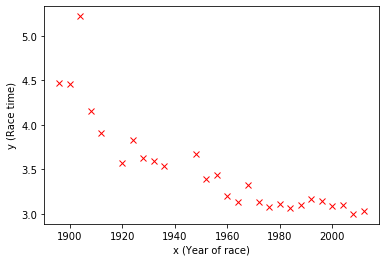

In [6]:
plt.plot(x, y, 'rx')
plt.ylabel("y (Race time)")
plt.xlabel("x (Year of race)")
plt.show()

### 3. Iterative solution (coordinate descent)

Expanding out the sum of square residuals for this simple case (where $\mathbf{w}=[w_0, w_1]$) we have:
$$SSR(w_0, w_1) = \sum_{i=1}^{n}(y_i - w_0 - w_1 x_i)^2$$
Let's start with an initial guess for the slope $w_1$ (which is clearly negative from the plot).

In [7]:
w1 = -0.4

Then using the maximum likelihood update, we get the following estimate for the intercept $w_0$:
$$w_0 = \frac{\sum_{i=1}^{n}(y_i-w_1 x_i)}{n}$$

In [8]:
def update_w0(x, y, w1):
    
    return ((y-(w1*x)).mean())

w0 = update_w0(x, y, w1)
print(w0)

786.0197711453593


Similarly, we can update $w_1$ based on this new estimate of $w_0$:
$$w_1 = \frac{\sum_{i=1}^{n} (y_i - w_0) \times x_i}{\sum_{i=1}^{n} x_i^2}$$

In [9]:
def update_w1(x, y, w0):
    w1=((y-w0)*x).sum()/(x**2).sum()
    return w1

w1 = update_w1(x, y, w0)
print(w1)

-0.3998724072997095


Let's examine the quality of fit for these values for the weights $w_0$ and $w_1$. We create a vector of "test" values `x_test` and a function to compute the predictions according to the model.

In [10]:
x_test = np.arange(1890, 2020)[:, None]

def predict(x_test, w0, w1): 
    return w0+(x_test*w1) #this is the forumla for the linear model which predicts y labels, and is given above in this document.

Now plot the test predictions with a blue line on the same plot as the data.

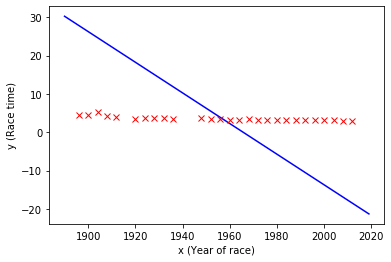

In [11]:
def plot_fit(x_test, y_test, x, y): 
    plt.plot(x_test, y_test, 'b-')
    plt.plot(x, y, 'rx')
    plt.ylabel("y (Race time)")
    plt.xlabel("x (Year of race)")
    plt.show()

plot_fit(x_test, predict(x_test, w0, w1), x, y)

We'll compute the sum of square residuals $SSR(w_0,w_1)$ on the training set to measure the goodness of fit.

In [12]:
def compute_SSR(x, y, w0, w1): 
    return ((y-w0-(w1*x))**2).sum()#the algorithm for computing SSR is given above

print(compute_SSR(x, y, w0, w1))

5104.580163103217


It's obvious from the plot that the fit isn't very good. 
We must repeat the alternating parameter updates many times before the algorithm converges to the optimal weights.

In [13]:
for i in np.arange(10000):
    w1 = update_w1(x, y, w0) 
    w0 = update_w0(x, y, w1) 
    if i % 500 == 0:
        print("Iteration #{}: SSR = {}".format(i, compute_SSR(x, y, w0, w1)))
print("Final estimates: w0 = {}; w1 = {}".format(w0, w1))

Iteration #0: SSR = 5102.897935763439
Iteration #500: SSR = 3670.1237324136036
Iteration #1000: SSR = 2639.7951157414004
Iteration #1500: SSR = 1898.870931140823
Iteration #2000: SSR = 1366.0616521953518
Iteration #2500: SSR = 982.9108067637796
Iteration #3000: SSR = 707.3815017083582
Iteration #3500: SSR = 509.24440022600925
Iteration #4000: SSR = 366.76114975678183
Iteration #4500: SSR = 264.29938710660775
Iteration #5000: SSR = 190.6176541954955
Iteration #5500: SSR = 137.6320562088593
Iteration #6000: SSR = 99.52934766658781
Iteration #6500: SSR = 72.12913980966421
Iteration #7000: SSR = 52.42525472313143
Iteration #7500: SSR = 38.2559064637811
Iteration #8000: SSR = 28.066523547010338
Iteration #8500: SSR = 20.73919117263098
Iteration #9000: SSR = 15.470000666868614
Iteration #9500: SSR = 11.680849695214238
Final estimates: w0 = 56.89456037769841; w1 = -0.027293057729518334


Let's try plotting the result again.

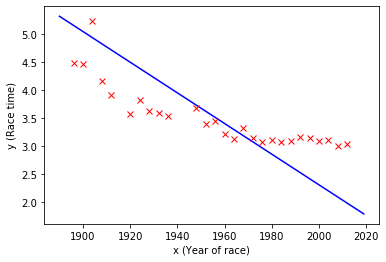

In [14]:
plot_fit(x_test, predict(x_test, w0, w1), x, y)

Does more than 10 iterations considerably improve fit in this case?

### 4. Linear algebra solution

In lectures, we saw that it's possible to solve for the optimal weights $\mathbf{w}^\star$ analytically. The solution is
$$\mathbf{w}^* = \left[\mathbf{X}^\top \mathbf{X}\right]^{-1} \mathbf{X}^\top \mathbf{y}$$
where
$$\mathbf{X} = \begin{pmatrix} 
        1 & x_1 \\ 1 & x_2 \\ \vdots & \vdots \\ 1 & x_n 
    \end{pmatrix} 
  \quad \text{and} \quad 
  \mathbf{y} = \begin{pmatrix} 
          y_1 \\ y_2 \\ \vdots \\ y_n
      \end{pmatrix}
$$

We construct $\mathbf{X}$ in the code block below, remembering to include the $x_0 = 1$ column for the bias (intercept).

In [15]:
X = np.hstack((np.ones_like(x), x))
print(X)

[[1.000e+00 1.896e+03]
 [1.000e+00 1.900e+03]
 [1.000e+00 1.904e+03]
 [1.000e+00 1.908e+03]
 [1.000e+00 1.912e+03]
 [1.000e+00 1.920e+03]
 [1.000e+00 1.924e+03]
 [1.000e+00 1.928e+03]
 [1.000e+00 1.932e+03]
 [1.000e+00 1.936e+03]
 [1.000e+00 1.948e+03]
 [1.000e+00 1.952e+03]
 [1.000e+00 1.956e+03]
 [1.000e+00 1.960e+03]
 [1.000e+00 1.964e+03]
 [1.000e+00 1.968e+03]
 [1.000e+00 1.972e+03]
 [1.000e+00 1.976e+03]
 [1.000e+00 1.980e+03]
 [1.000e+00 1.984e+03]
 [1.000e+00 1.988e+03]
 [1.000e+00 1.992e+03]
 [1.000e+00 1.996e+03]
 [1.000e+00 2.000e+03]
 [1.000e+00 2.004e+03]
 [1.000e+00 2.008e+03]
 [1.000e+00 2.012e+03]]


Although we can express $\mathbf{w}^\star$ explicitly in terms of the matrix inverse $(\mathbf{X}^\top \mathbf{X})^{-1}$, this isn't an efficient way to compute $\mathbf{w}$ numerically. It is better instead to solve the following system of linear equations:
$$\mathbf{X}^\top\mathbf{X} \mathbf{w}^\star = \mathbf{X}^\top\mathbf{y}$$

This can be done in numpy using the command

In [16]:
np.linalg.solve?

Signature: np.linalg.solve(a, b)
Docstring:
Solve a linear matrix equation, or system of linear scalar equations.

Computes the "exact" solution, `x`, of the well-determined, i.e., full
rank, linear matrix equation `ax = b`.

Parameters
----------
a : (..., M, M) array_like
    Coefficient matrix.
b : {(..., M,), (..., M, K)}, array_like
    Ordinate or "dependent variable" values.

Returns
-------
x : {(..., M,), (..., M, K)} ndarray
    Solution to the system a x = b.  Returned shape is identical to `b`.

Raises
------
LinAlgError
    If `a` is singular or not square.

Notes
-----

.. versionadded:: 1.8.0

Broadcasting rules apply, see the `numpy.linalg` documentation for
details.

The solutions are computed using LAPACK routine _gesv

`a` must be square and of full-rank, i.e., all rows (or, equivalently,
columns) must be linearly independent; if either is not true, use
`lstsq` for the least-squares best "solution" of the
system/equation.

References
----------
.. [1] G. Strang, *Lin

which gives

In [17]:
w=np.linalg.solve(np.dot(X.T,X),np.dot(X.T,y))
#w=np.dot(np.dot(np.linalg.inv(np.dot(X.T,X)),X.T),y)
print(w)

[[ 2.88952457e+01]
 [-1.29806477e-02]]


Plotting this solution, as before:

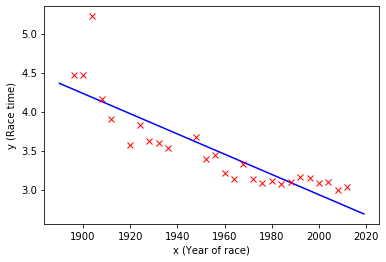

In [18]:
w0, w1 = w
plot_fit(x_test, predict(x_test, w0, w1), x, y)

You should verify that the sum of squared residuals $SSR(w_0, w_1)$, match or beats the earlier iterative result.

In [19]:
print(compute_SSR(x, y, w0, w1))

1.9799837689231614


**Note:** The error we computed above is the *training* error. It doesn't assess the model's generalization ability, it only assesses how well it's performing on the given training data. In later worksheets we'll assess the generalization ability of models using held-out evaluation data.

### 5. Solving using scikit-learn

Now that you have a good understanding of what's going on under the hood, you can use the functionality in `sklearn` to solve linear regression problems you encounter in the future. Using the `LinearRegression` module, fitting a linear regression model becomes a one-liner as shown below.

In [20]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression().fit(x, y)

The `LinearRegression` module provides access to the bias weight $w_0$ under the `intercept_` property

In [21]:
lr.intercept_

array([28.89524574])

and the non-bias weights under the `coef_` property

In [22]:
lr.coef_

array([[-0.01298065]])

You should check that these results match the solution you obtained previously. Note that sklearn also uses a numerical linear algebra solver under the hood.